In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
from matplotlib import patches
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

import os
import math
import random

import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Conv1D, Conv2D, Flatten, MaxPooling1D, MaxPooling2D
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.metrics import roc_curve, roc_auc_score, auc

import scipy.stats as st
from scipy.stats import poisson
from scipy.interpolate import interp1d
from scipy.stats import norm

In [2]:
from sklearn.neighbors import KernelDensity # paquete necesario
from sklearn.model_selection import GridSearchCV

import scipy.integrate as integrate

In [3]:
!pip install xgboost

import xgboost
from xgboost import XGBRegressor, XGBClassifier

You should consider upgrading via the '/home/andres/anaconda3/bin/python -m pip install --upgrade pip' command.


In [4]:
import h5py

import glob
import numpy as np
import os.path as path
import imageio
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, TensorBoard
from datetime import datetime
import keras
from keras import regularizers
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, average_precision_score, precision_recall_curve, auc,recall_score
#from keras.optimizers import Adam
from keras.regularizers import l2
import h5py
from sklearn.model_selection import GridSearchCV
from keras.backend import cast, greater, clip, floatx,epsilon
from keras.wrappers.scikit_learn import KerasClassifier
from keras import backend as K
from sklearn.model_selection import StratifiedKFold

### Load Data

In [63]:
filefolder = '../data2024/processed/'

###################
# BACKGROUND FILE #
###################

filename_B = 'ER/ER_all.hdf5'


###############
# SIGNAL FILE #
###############

# select the DM mass
mDM = 500

filename_S = 'mDM' + str(mDM) + 'GeV/WP_mDM' + str(mDM) + 'GeV_sig1045.hdf5'

##### Load the h5

In [64]:
# OPEN THE SAVED FILE TO CHECK IT
f_B = h5py.File(filefolder+filename_B,'r')
f_S = h5py.File(filefolder+filename_S,'r')

# show the groups
print( f_B.keys() )

# should be more than 10k events in each group
print('\n Background Events: ')
for groups1 in f_B.keys():
    print(len(f_B[groups1].keys()))

print('\n Signal Events')
for groups1 in f_S.keys():
    print(len(f_S[groups1].keys()))

<KeysViewHDF5 ['HITS_bot', 'HITS_bot_img', 'HITS_top', 'HITS_top_img', 'peakS1_onlyhits', 'peakS1_raw', 'peakS2_onlyhits', 'peakS2_raw']>

 Background Events: 
35549
35549
35549
35549
35549
35549
35549
35549

 Signal Events
32015
32015
32015
32015
32015
32015
32015
32015


In [66]:
################
# ALL THE DATA #
################


# to normalize
scaler = preprocessing.MinMaxScaler()

# Number of data points (per-class) for the ML classifier
#num_data = 30000
num_data = 1000


In [67]:
###################
# peakS1_onlyhits #
###################

# First:
# The max len for the time series

max_pS1_B = 0
max_pS1_S = 0

for i in range(1, num_data+1):
    max_pS1_B = max(max_pS1_B, len( f_B['peakS1_onlyhits/ev_'+str(i)] ))
    max_pS1_S = max(max_pS1_S, len( f_S['peakS1_onlyhits/ev_'+str(i)] ))
    
    
max_pS1_both = max(max_pS1_B,max_pS1_S)

print('max_pS1_both lenght: ', max_pS1_both)



# Second:
# add the events in a matrix, but all with the same length -> fill with zeros

# how many elements do we need to make all the peak (S1 or S2) arrays with the same length
diff_elem_S1_B = max_pS1_both - len( f_B['peakS1_onlyhits/ev_1'][()] )
diff_elem_S1_S = max_pS1_both - len( f_S['peakS1_onlyhits/ev_1'][()] )

# add zeros at the end
peakS1_onlyhits_B = np.pad(f_B['peakS1_onlyhits/ev_1'][()], (0, diff_elem_S1_B), 'constant')
peakS1_onlyhits_S = np.pad(f_S['peakS1_onlyhits/ev_1'][()], (0, diff_elem_S1_S), 'constant')

for i in range(2, num_data+1):
    
    # how many elements do we need to make all the peak (S1 or S2) arrays with the same length
    diff_elem_S1_B = max_pS1_both - len( f_B['peakS1_onlyhits/ev_'+str(i)][()] )
    diff_elem_S1_S = max_pS1_both - len( f_S['peakS1_onlyhits/ev_'+str(i)][()] )
    
    # add zeros at the end
    aux_S1_B = np.pad(f_B['peakS1_onlyhits/ev_'+str(i)][()], (0, diff_elem_S1_B), 'constant')
    aux_S1_S = np.pad(f_S['peakS1_onlyhits/ev_'+str(i)][()], (0, diff_elem_S1_S), 'constant')
    
    # add new event to the matrix as a row
    peakS1_onlyhits_B = np.row_stack([peakS1_onlyhits_B,aux_S1_B])
    peakS1_onlyhits_S = np.row_stack([peakS1_onlyhits_S,aux_S1_S])
    
    
    

# X and Y for the classifier
X_peakS1 = np.row_stack([peakS1_onlyhits_B,peakS1_onlyhits_S])
# normalize
X_peakS1 = scaler.fit_transform(X_peakS1)

del peakS1_onlyhits_B
del peakS1_onlyhits_S






###################
# CONCATENATE ALL #
###################

X_mon1 = np.concatenate([X_peakS1],axis=1)

del X_peakS1

# labels
y_mon1 = np.concatenate([np.zeros(num_data),np.ones(num_data)])


# divide into train-val and test data samples
test_ratio = 1./3
val_ratio = 0.25


X_mon1_aux, X_mon1_test, y_mon1_aux, y_mon1_test = train_test_split(X_mon1,
                                                                y_mon1,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_mon1,
                                                                shuffle=True)

del X_mon1
del y_mon1

X_mon1_train, X_mon1_val, y_mon1_train, y_mon1_val = train_test_split(X_mon1_aux,
                                                                  y_mon1_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_mon1_aux,
                                                                  shuffle=True)

del X_mon1_aux
del y_mon1_aux

print('')
print('X_mon1_train : ', X_mon1_train.shape)
print('y_mon1_train : ', y_mon1_train.shape)
print('X_mon1_val : ', X_mon1_val.shape)
print('y_mon1_val : ', y_mon1_val.shape)
print('X_mon1_test : ', X_mon1_test.shape)
print('y_mon1_test : ', y_mon1_test.shape)
print('')

max_pS1_both lenght:  147

X_mon1_train :  (999, 147)
y_mon1_train :  (999,)
X_mon1_val :  (334, 147)
y_mon1_val :  (334,)
X_mon1_test :  (667, 147)
y_mon1_test :  (667,)



In [68]:
###################
# peakS2_onlyhits #
###################

# First:
# The max len for the time series

max_pS2_B = 0
max_pS2_S = 0

for i in range(1, num_data+1):
    max_pS2_B = max(max_pS2_B, len( f_B['peakS2_onlyhits/ev_'+str(i)] ))
    max_pS2_S = max(max_pS2_S, len( f_S['peakS2_onlyhits/ev_'+str(i)] ))
    
    
max_pS2_both = max(max_pS2_B,max_pS2_S)

print('max_pS2_both lenght: ', max_pS2_both)



# Second:
# add the events in a matrix, but all with the same length -> fill with zeros

# how many elements do we need to make all the peak (S2 or S2) arrays with the same length
diff_elem_S2_B = max_pS2_both - len( f_B['peakS2_onlyhits/ev_1'][()] )
diff_elem_S2_S = max_pS2_both - len( f_S['peakS2_onlyhits/ev_1'][()] )

# add zeros at the end
peakS2_onlyhits_B = np.pad(f_B['peakS2_onlyhits/ev_1'][()], (0, diff_elem_S2_B), 'constant')
peakS2_onlyhits_S = np.pad(f_S['peakS2_onlyhits/ev_1'][()], (0, diff_elem_S2_S), 'constant')

for i in range(2, num_data+1):
    
    # how many elements do we need to make all the peak (S2 or S2) arrays with the same length
    diff_elem_S2_B = max_pS2_both - len( f_B['peakS2_onlyhits/ev_'+str(i)][()] )
    diff_elem_S2_S = max_pS2_both - len( f_S['peakS2_onlyhits/ev_'+str(i)][()] )
    
    # add zeros at the end
    aux_S2_B = np.pad(f_B['peakS2_onlyhits/ev_'+str(i)][()], (0, diff_elem_S2_B), 'constant')
    aux_S2_S = np.pad(f_S['peakS2_onlyhits/ev_'+str(i)][()], (0, diff_elem_S2_S), 'constant')
    
    # add new event to the matrix as a row
    peakS2_onlyhits_B = np.row_stack([peakS2_onlyhits_B,aux_S2_B])
    peakS2_onlyhits_S = np.row_stack([peakS2_onlyhits_S,aux_S2_S])
    
    
    

# X and Y for the classifier
X_peakS2 = np.row_stack([peakS2_onlyhits_B,peakS2_onlyhits_S])
# normalize
X_peakS2 = scaler.fit_transform(X_peakS2)

del peakS2_onlyhits_B
del peakS2_onlyhits_S









###################
# CONCATENATE ALL #
###################

X_mon2 = np.concatenate([X_peakS2],axis=1)

del X_peakS2

# labels
y_mon2 = np.concatenate([np.zeros(num_data),np.ones(num_data)])


# divide into train-val and test data samples
test_ratio = 1./3
val_ratio = 0.25


X_mon2_aux, X_mon2_test, y_mon2_aux, y_mon2_test = train_test_split(X_mon2,
                                                                y_mon2,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_mon2,
                                                                shuffle=True)

del X_mon2
del y_mon2

X_mon2_train, X_mon2_val, y_mon2_train, y_mon2_val = train_test_split(X_mon2_aux,
                                                                  y_mon2_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_mon2_aux,
                                                                  shuffle=True)

del X_mon2_aux
del y_mon2_aux

print('')
print('X_mon2_train : ', X_mon2_train.shape)
print('y_mon2_train : ', y_mon2_train.shape)
print('X_mon2_val : ', X_mon2_val.shape)
print('y_mon2_val : ', y_mon2_val.shape)
print('X_mon2_test : ', X_mon2_test.shape)
print('y_mon2_test : ', y_mon2_test.shape)
print('')

max_pS2_both lenght:  2298

X_mon2_train :  (999, 2298)
y_mon2_train :  (999,)
X_mon2_val :  (334, 2298)
y_mon2_val :  (334,)
X_mon2_test :  (667, 2298)
y_mon2_test :  (667,)



In [69]:
######################
# ONLY HITS_bot DATA #
######################


hits_bot_B = np.array( f_B['HITS_bot_img/ev_1'] )
hits_bot_S = np.array( f_S['HITS_bot_img/ev_1'] )


for i in range(2,num_data+1):
    # add new event to the matrix as a row
    hits_bot_B = np.row_stack([hits_bot_B,np.array( f_B['HITS_bot_img/ev_'+str(i)] )])
    hits_bot_S = np.row_stack([hits_bot_S,np.array( f_S['HITS_bot_img/ev_'+str(i)] )])
    
    



# X and Y for the classifier
X_mon3 = np.row_stack([hits_bot_B,hits_bot_S])
# normalize
X_mon3 = scaler.fit_transform(X_mon3)
#X_mon3 = np.reshape(X_mon3, (2*num_data,128,128,1))

del hits_bot_B
del hits_bot_S

# labels
y_mon3 = np.concatenate([np.zeros(num_data),np.ones(num_data)])



# divide into train-val and test data samples
test_ratio = 1./3
val_ratio = 0.25


X_mon3_aux, X_mon3_test, y_mon3_aux, y_mon3_test = train_test_split(X_mon3,
                                                                y_mon3,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_mon3,
                                                                shuffle=True)

del X_mon3
del y_mon3

X_mon3_train, X_mon3_val, y_mon3_train, y_mon3_val = train_test_split(X_mon3_aux,
                                                                  y_mon3_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_mon3_aux,
                                                                  shuffle=True)

del X_mon3_aux
del y_mon3_aux

print('')
print('X_mon3_train : ', X_mon3_train.shape)
print('y_mon3_train : ', y_mon3_train.shape)
print('X_mon3_val : ', X_mon3_val.shape)
print('y_mon3_val : ', y_mon3_val.shape)
print('X_mon3_test : ', X_mon3_test.shape)
print('y_mon3_test : ', y_mon3_test.shape)
print('')


X_mon3_train :  (999, 16384)
y_mon3_train :  (999,)
X_mon3_val :  (334, 16384)
y_mon3_val :  (334,)
X_mon3_test :  (667, 16384)
y_mon3_test :  (667,)



In [70]:
######################
# ONLY HITS_top DATA #
######################


hits_top_B = np.array( f_B['HITS_top_img/ev_1'] )
hits_top_S = np.array( f_S['HITS_top_img/ev_1'] )


for i in range(2,num_data+1):
    # add new event to the matrix as a row
    hits_top_B = np.row_stack([hits_top_B,np.array( f_B['HITS_top_img/ev_'+str(i)] )])
    hits_top_S = np.row_stack([hits_top_S,np.array( f_S['HITS_top_img/ev_'+str(i)] )])
    
    



# X and Y for the classifier
X_mon4 = np.row_stack([hits_top_B,hits_top_S])
# normalize
X_mon4 = scaler.fit_transform(X_mon4)
#X_mon4 = np.reshape(X_mon4, (2*num_data,128,128,1))

del hits_top_B
del hits_top_S

# labels
y_mon4 = np.concatenate([np.zeros(num_data),np.ones(num_data)])



# divide into train-val and test data samples
test_ratio = 1./3
val_ratio = 0.25


X_mon4_aux, X_mon4_test, y_mon4_aux, y_mon4_test = train_test_split(X_mon4,
                                                                y_mon4,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_mon4,
                                                                shuffle=True)

del X_mon4
del y_mon4

X_mon4_train, X_mon4_val, y_mon4_train, y_mon4_val = train_test_split(X_mon4_aux,
                                                                  y_mon4_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_mon4_aux,
                                                                  shuffle=True)

del X_mon4_aux
del y_mon4_aux

print('')
print('X_mon4_train : ', X_mon4_train.shape)
print('y_mon4_train : ', y_mon4_train.shape)
print('X_mon4_val : ', X_mon4_val.shape)
print('y_mon4_val : ', y_mon4_val.shape)
print('X_mon4_test : ', X_mon4_test.shape)
print('y_mon4_test : ', y_mon4_test.shape)
print('')


X_mon4_train :  (999, 16384)
y_mon4_train :  (999,)
X_mon4_val :  (334, 16384)
y_mon4_val :  (334,)
X_mon4_test :  (667, 16384)
y_mon4_test :  (667,)



In [71]:
# close the h5 files
f_B.close()
f_S.close()

##### Load the compressed features

B_pbot.shape:  (35549,)
B_ptop.shape:  (35549,)
B_ppeakS1.shape : (35549, 8)
B_ppeakS2.shape:  (35549, 8)
S_pbot.shape:  (32015,)
S_ptop.shape:  (32015,)
S_ppeakS1.shape : (32015, 8)
S_ppeakS2.shape:  (32015, 8)


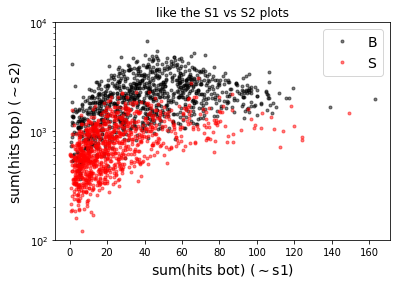

In [72]:
B_pbot = np.loadtxt(filefolder + 'ER/pbot.txt')
B_ptop = np.loadtxt(filefolder + 'ER/ptop.txt')
B_ppeakS1 = np.loadtxt(filefolder + 'ER/ppeakS1.txt')
B_ppeakS2 = np.loadtxt(filefolder + 'ER/ppeakS2.txt')

print('B_pbot.shape: ', B_pbot.shape)
print('B_ptop.shape: ', B_ptop.shape)
print('B_ppeakS1.shape :', B_ppeakS1.shape)
print('B_ppeakS2.shape: ', B_ppeakS2.shape)



S_pbot = np.loadtxt(filefolder + 'mDM' + str(mDM) + 'GeV/pbot.txt')
S_ptop = np.loadtxt(filefolder + 'mDM' + str(mDM) + 'GeV/ptop.txt')
S_ppeakS1 = np.loadtxt(filefolder + 'mDM' + str(mDM) + 'GeV/ppeakS1.txt')
S_ppeakS2 = np.loadtxt(filefolder + 'mDM' + str(mDM) + 'GeV/ppeakS2.txt')

print('S_pbot.shape: ', S_pbot.shape)
print('S_ptop.shape: ', S_ptop.shape)
print('S_ppeakS1.shape :', S_ppeakS1.shape)
print('S_ppeakS2.shape: ', S_ppeakS2.shape)


# plot to check

plt.plot(B_pbot[:1000], B_ptop[:1000], '.', color='black', alpha=0.5, label='B')
plt.plot(S_pbot[:1000], S_ptop[:1000], '.', color='red', alpha=0.5, label='S')
plt.yscale('log')
# plt.xlim([0,100])
plt.ylim([100,10000])
plt.xlabel(r'sum(hits bot) ($\sim$s1)',fontsize=14)
plt.ylabel(r'sum(hits top) ($\sim$s2)',fontsize=14)
plt.title('like the S1 vs S2 plots')
plt.legend(fontsize=14)
plt.show()

B_pbot.shape:  (1000,)
B_ptop.shape:  (1000,)
B_ppeakS1.shape : (1000, 8)
B_ppeakS2.shape:  (1000, 8)
S_pbot.shape:  (1000,)
S_ptop.shape:  (1000,)
S_ppeakS1.shape : (1000, 8)
S_ppeakS2.shape:  (1000, 8)
B_pdiffT.shape:  (1000,)
S_pdiffT.shape:  (1000,)


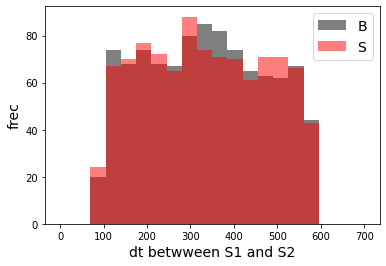

In [73]:
# to have the same number of background and signal events

B_pbot = B_pbot[:num_data]
B_ptop = B_ptop[:num_data]
B_ppeakS1 = B_ppeakS1[:num_data]
B_ppeakS2 = B_ppeakS2[:num_data]

print('B_pbot.shape: ', B_pbot.shape)
print('B_ptop.shape: ', B_ptop.shape)
print('B_ppeakS1.shape :', B_ppeakS1.shape)
print('B_ppeakS2.shape: ', B_ppeakS2.shape)


S_pbot = S_pbot[:num_data]
S_ptop = S_ptop[:num_data]
S_ppeakS1 = S_ppeakS1[:num_data]
S_ppeakS2 = S_ppeakS2[:num_data]

print('S_pbot.shape: ', S_pbot.shape)
print('S_ptop.shape: ', S_ptop.shape)
print('S_ppeakS1.shape :', S_ppeakS1.shape)
print('S_ppeakS2.shape: ', S_ppeakS2.shape)


# CONSTRUCT THE TIME DIFFERENCE BETWEEN PULSES

B_pdiffT = B_ppeakS2[:,0] - B_ppeakS1[:,0]
S_pdiffT = S_ppeakS2[:,0] - S_ppeakS1[:,0]

print('B_pdiffT.shape: ', B_pdiffT.shape)
print('S_pdiffT.shape: ', S_pdiffT.shape)


plt.hist(B_pdiffT, range=[0,700], bins=20, color='black', alpha=0.5, label='B')
plt.hist(S_pdiffT, range=[0,700], bins=20, color='red', alpha=0.5, label='S')
# plt.yscale('log')
# plt.xlim([0,100])
# plt.ylim([100,10000])
plt.xlabel('dt betwween S1 and S2',fontsize=14)
plt.ylabel('frec',fontsize=14)
plt.legend(fontsize=14)
plt.show()

##### Remove the absolute times of each pulse (we just need the time difference between pulses
other variables also can be removed if you want

In [74]:
remove_col = [0] # index = 0 is pT0

B_pbot = B_pbot
B_ptop = B_ptop
B_ppeakS1 = np.delete(B_ppeakS1, remove_col, axis=1)
B_ppeakS2 = np.delete(B_ppeakS2, remove_col, axis=1)

print('B_pbot.shape: ', B_pbot.shape)
print('B_ptop.shape: ', B_ptop.shape)
print('B_ppeakS1.shape :', B_ppeakS1.shape)
print('B_ppeakS2.shape: ', B_ppeakS2.shape)


S_pbot = S_pbot
S_ptop = S_ptop
S_ppeakS1 = np.delete(S_ppeakS1, remove_col, axis=1)
S_ppeakS2 = np.delete(S_ppeakS2, remove_col, axis=1)

print('S_pbot.shape: ', S_pbot.shape)
print('S_ptop.shape: ', S_ptop.shape)
print('S_ppeakS1.shape :', S_ppeakS1.shape)
print('S_ppeakS2.shape: ', S_ppeakS2.shape)

B_pbot.shape:  (1000,)
B_ptop.shape:  (1000,)
B_ppeakS1.shape : (1000, 7)
B_ppeakS2.shape:  (1000, 7)
S_pbot.shape:  (1000,)
S_ptop.shape:  (1000,)
S_ppeakS1.shape : (1000, 7)
S_ppeakS2.shape:  (1000, 7)


In [75]:
# concatenate the data

# all the background features
X_mon_B = np.concatenate([B_ppeakS1, B_ppeakS2, np.reshape(B_pbot,(len(B_pbot),1)), np.reshape(B_ptop,(len(B_ptop),1)), np.reshape(B_pdiffT,(len(B_pdiffT),1)) ],axis=1)

# all the signal features
X_mon_S = np.concatenate([S_ppeakS1, S_ppeakS2, np.reshape(S_pbot,(len(S_pbot),1)), np.reshape(S_ptop,(len(S_ptop),1)), np.reshape(S_pdiffT,(len(S_pdiffT),1)) ],axis=1)

print('X_mon_B.shape: ', X_mon_B.shape)
print('X_mon_S.shape: ', X_mon_S.shape)
print('')

del B_ppeakS1
del B_ppeakS2
del B_pbot
del B_ptop

del S_ppeakS1
del S_ppeakS2
del S_pbot
del S_ptop


X_mon5 = np.concatenate([X_mon_B, X_mon_S])

print('X_mon5.shape: ', X_mon5.shape)
del X_mon_B
del X_mon_S


# labels
y_mon5 = np.concatenate([np.zeros(num_data),np.ones(num_data)])




# divide into train-val and test data samples
test_ratio = 1./3
val_ratio = 0.25


X_mon5_aux, X_mon5_test, y_mon5_aux, y_mon5_test = train_test_split(X_mon5,
                                                                y_mon5,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_mon5,
                                                                shuffle=True)

del X_mon5
del y_mon5

X_mon5_train, X_mon5_val, y_mon5_train, y_mon5_val = train_test_split(X_mon5_aux,
                                                                  y_mon5_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_mon5_aux,
                                                                  shuffle=True)

del X_mon5_aux
del y_mon5_aux

print('')
print('X_mon5_train : ', X_mon5_train.shape)
print('y_mon5_train : ', y_mon5_train.shape)
print('X_mon5_val : ', X_mon5_val.shape)
print('y_mon5_val : ', y_mon5_val.shape)
print('X_mon5_test : ', X_mon5_test.shape)
print('y_mon5_test : ', y_mon5_test.shape)
print('')

X_mon_B.shape:  (1000, 17)
X_mon_S.shape:  (1000, 17)

X_mon5.shape:  (2000, 17)

X_mon5_train :  (999, 17)
y_mon5_train :  (999,)
X_mon5_val :  (334, 17)
y_mon5_val :  (334,)
X_mon5_test :  (667, 17)
y_mon5_test :  (667,)



##### Concatenate into one single big dataset

In [80]:
X_mon_train = np.concatenate([X_mon1_train,X_mon2_train,X_mon3_train,X_mon4_train,X_mon5_train],axis=1)
X_mon_test = np.concatenate([X_mon1_test,X_mon2_test,X_mon3_test,X_mon4_test,X_mon5_test],axis=1)
X_mon_val = np.concatenate([X_mon1_val,X_mon2_val,X_mon3_val,X_mon4_val,X_mon5_val],axis=1)

del X_mon1_train
del X_mon2_train
del X_mon3_train
del X_mon4_train
del X_mon5_train

del X_mon1_test
del X_mon2_test
del X_mon3_test
del X_mon4_test
del X_mon5_test

del X_mon1_val
del X_mon2_val
del X_mon3_val
del X_mon4_val
del X_mon5_val



y_mon_train = y_mon1_train
y_mon_test = y_mon1_test
y_mon_val = y_mon1_val

del y_mon1_train
del y_mon2_train
del y_mon3_train
del y_mon4_train
del y_mon5_train

del y_mon1_test
del y_mon2_test
del y_mon3_test
del y_mon4_test
del y_mon5_test

del y_mon1_val
del y_mon2_val
del y_mon3_val
del y_mon4_val
del y_mon5_val


In [81]:
print('')
print('X_mon_train : ', X_mon_train.shape)
print('y_mon_train : ', y_mon_train.shape)
print('X_mon_val : ', X_mon_val.shape)
print('y_mon_val : ', y_mon_val.shape)
print('X_mon_test : ', X_mon_test.shape)
print('y_mon_test : ', y_mon_test.shape)
print('')


X_mon_train :  (999, 35230)
y_mon_train :  (999,)
X_mon_val :  (334, 35230)
y_mon_val :  (334,)
X_mon_test :  (667, 35230)
y_mon_test :  (667,)



### CLASSIFIER

### XGBoost

/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-logloss:0.61529	validation_1-logloss:0.62587
[1]	validation_0-logloss:0.55112	validation_1-logloss:0.57933
[2]	validation_0-logloss:0.49626	validation_1-logloss:0.54087
[3]	validation_0-logloss:0.44829	validation_1-logloss:0.50541
[4]	validation_0-logloss:0.40647	validation_1-logloss:0.47371
[5]	validation_0-logloss:0.37088	validation_1-logloss:0.44316
[6]	validation_0-logloss:0.33815	validation_1-logloss:0.41848
[7]	validation_0-logloss:0.31027	validation_1-logloss:0.39815
[8]	validation_0-logloss:0.28521	validation_1-logloss:0.38070
[9]	validation_0-logloss:0.26145	validation_1-logloss:0.36496
[10]	validation_0-logloss:0.24080	validation_1-logloss:0.34860
[11]	validation_0-logloss:0.22351	validation_1-logloss:0.33810
[12]	validation_0-logloss:0.20708	validation_1-logloss:0.32515
[13]	validation_0-logloss:0.19155	validation_1-logloss:0.31449
[14]	validation_0-logloss:0.17871	validation_1-logloss:0.30563
[15]	validation_0-logloss:0.16551	validation_1-logloss:0.29737
[1

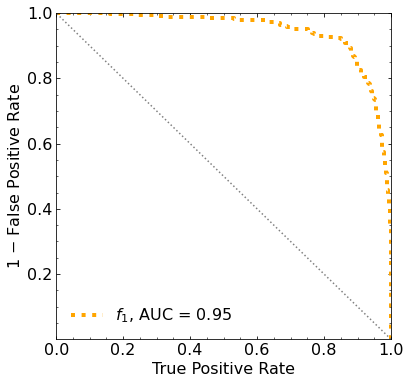

Classification score:


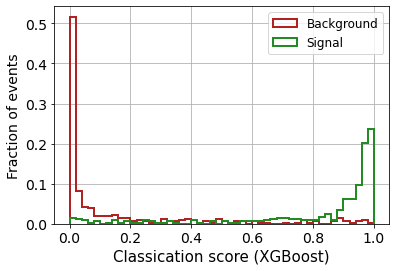


 ROC-AUC =  0.9461610402690599


In [82]:
# XGBoost with only the kinematic variables of the leptons

# CLASSIFIER
classifier = XGBClassifier(
    n_estimators=1500,
    learning_rate=0.1,
    reg_lambda=0.0,reg_alpha=0.0,
    gamma=0.0,objective='binary:logistic',
    max_depth=5,
    #eval_metric=["error", "logloss", "map"]
    eval_metric='logloss')

# FIT
classifier.fit(X_mon_train,y_mon_train,eval_set=[(X_mon_train, y_mon_train), (X_mon_val, y_mon_val)],
        early_stopping_rounds=50,#early stopping
        verbose=True)


# PREDICTIONS
y_pred_xg = classifier.predict_proba(X_mon_test).T[1]


# ROC
fpr_mon_xg, tpr_mon_xg, _ = roc_curve(y_mon_test, y_pred_xg)
roc_auc_xg = auc(fpr_mon_xg, tpr_mon_xg)


# PLOT THE ROC WITH AUC
fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax0.minorticks_on()


plt.plot(tpr_mon_xg,1-fpr_mon_xg,label="$f_{1}$, AUC = %0.2f" % roc_auc_xg,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()



# XGBoost with the kinematic variables of the leptons

########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_xg[i])
    else:
        pred_XG_NP.append(y_pred_xg[i])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()




print('\n ROC-AUC = ', roc_auc_xg)

In [83]:
print('\n ROC-AUC = ', roc_auc_xg)


 ROC-AUC =  0.9461610402690599


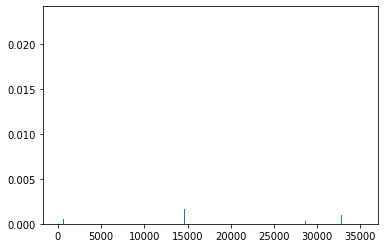

In [84]:
plt.bar(range(len(classifier.feature_importances_)), classifier.feature_importances_)
plt.show()

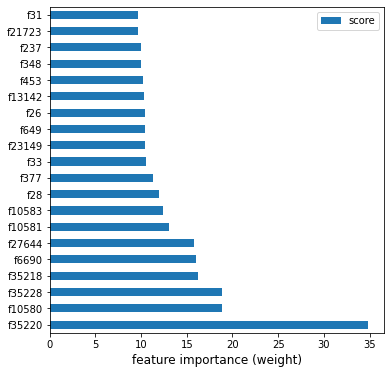


peakS1:     147 features  --> f0 to f146
peakS2:    2298 features  --> f147 to f2444
hits bot: 16384 features  --> f2445 to f18828
hits top: 16384 features  --> f18829 to f35212
resumed:     17 features  --> f35213 to f35229

f35213: pA_S1 
f35214: pH_S1 
f35215: pHT_S1 
f35216: pL_S1 
f35217: pL90_S1 
f35218: pRMSW_S1 
f35219: pHTL_S1 
f35220: pA_S2 
f35221: pH_S2 
f35222: pHT_S2 
f35223: pL_S2 
f35224: pL90_S2 
f35225: pRMSW_S2 
f35226: pHTL_S2 
f35227: pbot 
f35228: ptop 
f35229: pdiffT


In [92]:
feature_important = classifier.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
#keys = ['pA_S1','pH_S1','pHT_S1','pL_S1','pL90_S1','pRMSW_S1','pHTL_S1','pA_S2','pH_S2','pHT_S2','pL_S2','pL90_S2','pRMSW_S2','pHTL_S2','pbot', 'ptop','pdiffT']
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(20, columns="score").plot(kind='barh', figsize = (6,6)) ## plot top 10 features
plt.xlabel('feature importance (weight)', fontsize = 12)
plt.show()

print('\npeakS1:     147 features  --> f0 to f146')
print('peakS2:    2298 features  --> f147 to f2444')
print('hits bot: 16384 features  --> f2445 to f18828')
print('hits top: 16384 features  --> f18829 to f35212')
print('resumed:     17 features  --> f35213 to f35229')

print('\nf35213: pA_S1',
      '\nf35214: pH_S1',
      '\nf35215: pHT_S1',
      '\nf35216: pL_S1',
      '\nf35217: pL90_S1',
      '\nf35218: pRMSW_S1',
      '\nf35219: pHTL_S1',
      '\nf35220: pA_S2',
      '\nf35221: pH_S2',
      '\nf35222: pHT_S2',
      '\nf35223: pL_S2',
      '\nf35224: pL90_S2',
      '\nf35225: pRMSW_S2',
      '\nf35226: pHTL_S2',
      '\nf35227: pbot', 
      '\nf35228: ptop',
      '\nf35229: pdiffT')

### DNN

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 32)                1127392   
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_5 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 68        
_________________________________________________________________
dropout_6 (Dropout)          (None, 4)                 0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                

8/8 [==============================] - 0s 12ms/step - loss: 0.3182 - accuracy: 0.8281 - val_loss: 0.2479 - val_accuracy: 0.9042
Epoch 51/500
8/8 [==============================] - 0s 21ms/step - loss: 0.3235 - accuracy: 0.8364 - val_loss: 0.2650 - val_accuracy: 0.9072
Epoch 52/500
8/8 [==============================] - 0s 40ms/step - loss: 0.3040 - accuracy: 0.8466 - val_loss: 0.2406 - val_accuracy: 0.9162
Epoch 53/500
8/8 [==============================] - 0s 20ms/step - loss: 0.3707 - accuracy: 0.7928 - val_loss: 0.2860 - val_accuracy: 0.8114
Epoch 54/500
8/8 [==============================] - 0s 17ms/step - loss: 0.3512 - accuracy: 0.7801 - val_loss: 0.2988 - val_accuracy: 0.8054
Epoch 55/500
8/8 [==============================] - 0s 18ms/step - loss: 0.3707 - accuracy: 0.7807 - val_loss: 0.2427 - val_accuracy: 0.9072
Epoch 56/500
8/8 [==============================] - 0s 13ms/step - loss: 0.3051 - accuracy: 0.8067 - val_loss: 0.2524 - val_accuracy: 0.9102
Epoch 57/500
8/8 [========

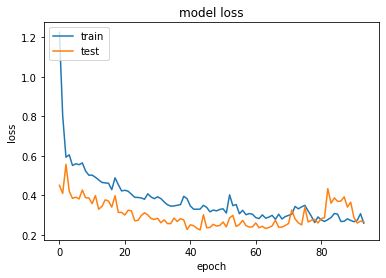

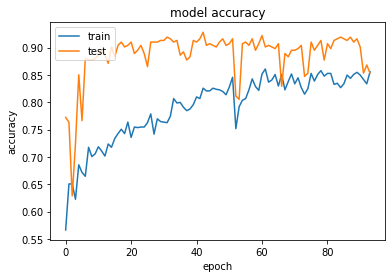

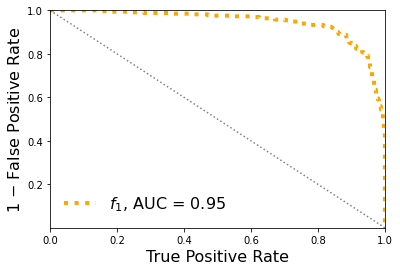

Classification score:


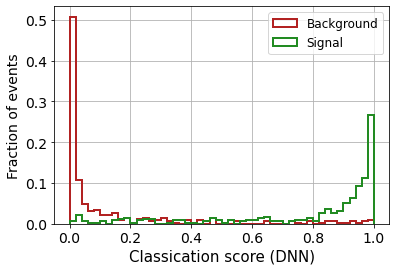


 ROC-AUC =  0.9463319005053866


In [94]:

# define the keras model
model = Sequential()
model.add(Dense(32, input_shape=(X_mon_train.shape[1],), activation='relu'))
model.add(Dropout(0.20))
# model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.20))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(4, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_dnn = model.predict(X_mon_test)

# Compute ROC curve and ROC area for each class
fpr_dnn = dict()
tpr_dnn = dict()
roc_auc_dnn = dict()
fpr_dnn, tpr_dnn, _ = roc_curve(y_mon_test, y_pred_dnn)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)


plt.figure()
plt.plot(tpr_dnn,1-fpr_dnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_dnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_dnn[i,0])
    else:
        pred_XG_NP.append(y_pred_dnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (DNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_dnn)

### CNN

In [95]:
# prepare the dataset
X_mon_train_cn = X_mon_train.reshape(X_mon_train.shape[0], X_mon_train.shape[1], 1)
X_mon_test_cn = X_mon_test.reshape(X_mon_test.shape[0], X_mon_test.shape[1], 1)
X_mon_val_cn = X_mon_val.reshape(X_mon_val.shape[0], X_mon_val.shape[1], 1)

In [96]:

# define the keras model
model = Sequential()
model.add(Conv1D(16, 2, input_shape=(X_mon_train.shape[1],1), activation='relu', strides = (1),kernel_regularizer=l2(0.005)))
model.add(MaxPooling1D(2, strides = (1)))
model.add(Conv1D(16, 2, input_shape=(X_mon_train.shape[1],1), activation='relu', strides = (1),kernel_regularizer=l2(0.005)))
model.add(MaxPooling1D(2, strides = (1)))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))


# Print the model summary
#model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train_cn,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val_cn, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_cnn = model.predict(X_mon_test_cn)

# Compute ROC curve and ROC area for each class
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()
fpr_cnn, tpr_cnn, _ = roc_curve(y_mon_test, y_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)


plt.figure()
plt.plot(tpr_cnn,1-fpr_cnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_cnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_cnn[i,0])
    else:
        pred_XG_NP.append(y_pred_cnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (CNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_cnn)

Epoch 1/500
8/8 [==============================] - 19s 2s/step - loss: 7.6336 - accuracy: 0.5538 - val_loss: 0.7790 - val_accuracy: 0.4671
Epoch 2/500
8/8 [==============================] - 15s 2s/step - loss: 0.7785 - accuracy: 0.5074 - val_loss: 0.7774 - val_accuracy: 0.4671
Epoch 3/500
8/8 [==============================] - 15s 2s/step - loss: 0.7768 - accuracy: 0.4995 - val_loss: 0.7757 - val_accuracy: 0.4671
Epoch 4/500
8/8 [==============================] - 15s 2s/step - loss: 0.7750 - accuracy: 0.4991 - val_loss: 0.7740 - val_accuracy: 0.4671
Epoch 5/500
8/8 [==============================] - 15s 2s/step - loss: 0.7734 - accuracy: 0.4995 - val_loss: 0.7725 - val_accuracy: 0.4671
Epoch 6/500
8/8 [==============================] - 15s 2s/step - loss: 0.7717 - accuracy: 0.5123 - val_loss: 0.7710 - val_accuracy: 0.4671
Epoch 7/500
8/8 [==============================] - 15s 2s/step - loss: 0.7703 - accuracy: 0.5029 - val_loss: 0.7696 - val_accuracy: 0.4671
Epoch 8/500
8/8 [==========

8/8 [==============================] - 15s 2s/step - loss: 0.7422 - accuracy: 0.5371 - val_loss: 0.7436 - val_accuracy: 0.4671
Epoch 60/500
8/8 [==============================] - 15s 2s/step - loss: 0.7423 - accuracy: 0.5206 - val_loss: 0.7433 - val_accuracy: 0.4671
Epoch 61/500
8/8 [==============================] - 15s 2s/step - loss: 0.7429 - accuracy: 0.4856 - val_loss: 0.7431 - val_accuracy: 0.4671
Epoch 62/500
8/8 [==============================] - 15s 2s/step - loss: 0.7425 - accuracy: 0.4919 - val_loss: 0.7429 - val_accuracy: 0.4671
Epoch 63/500
8/8 [==============================] - 15s 2s/step - loss: 0.7423 - accuracy: 0.4922 - val_loss: 0.7427 - val_accuracy: 0.4671
Epoch 64/500
8/8 [==============================] - 15s 2s/step - loss: 0.7416 - accuracy: 0.5125 - val_loss: 0.7425 - val_accuracy: 0.4671
Epoch 65/500
8/8 [==============================] - 15s 2s/step - loss: 0.7414 - accuracy: 0.5122 - val_loss: 0.7423 - val_accuracy: 0.4671
Epoch 66/500
8/8 [===============

8/8 [==============================] - 15s 2s/step - loss: 0.7314 - accuracy: 0.5124 - val_loss: 0.7324 - val_accuracy: 0.4671
Epoch 118/500
8/8 [==============================] - 15s 2s/step - loss: 0.7311 - accuracy: 0.5170 - val_loss: 0.7323 - val_accuracy: 0.4671
Epoch 119/500
8/8 [==============================] - 15s 2s/step - loss: 0.7313 - accuracy: 0.5035 - val_loss: 0.7321 - val_accuracy: 0.4671
Epoch 120/500
8/8 [==============================] - 15s 2s/step - loss: 0.7310 - accuracy: 0.5070 - val_loss: 0.7319 - val_accuracy: 0.4671
Epoch 121/500
8/8 [==============================] - 14s 2s/step - loss: 0.7315 - accuracy: 0.4796 - val_loss: 0.7317 - val_accuracy: 0.4671
Epoch 122/500
8/8 [==============================] - 15s 2s/step - loss: 0.7305 - accuracy: 0.5118 - val_loss: 0.7315 - val_accuracy: 0.4671
Epoch 123/500
8/8 [==============================] - 15s 2s/step - loss: 0.7301 - accuracy: 0.5235 - val_loss: 0.7314 - val_accuracy: 0.4671
Epoch 124/500
8/8 [========

8/8 [==============================] - 17s 2s/step - loss: 0.7224 - accuracy: 0.5069 - val_loss: 0.7233 - val_accuracy: 0.4671
Epoch 176/500
8/8 [==============================] - 17s 2s/step - loss: 0.7222 - accuracy: 0.5094 - val_loss: 0.7231 - val_accuracy: 0.4671
Epoch 177/500
8/8 [==============================] - 16s 2s/step - loss: 0.7222 - accuracy: 0.5026 - val_loss: 0.7230 - val_accuracy: 0.4671
Epoch 178/500
8/8 [==============================] - 17s 2s/step - loss: 0.7218 - accuracy: 0.5140 - val_loss: 0.7229 - val_accuracy: 0.4671
Epoch 179/500
8/8 [==============================] - 17s 2s/step - loss: 0.7219 - accuracy: 0.5044 - val_loss: 0.7227 - val_accuracy: 0.4671
Epoch 180/500
8/8 [==============================] - 17s 2s/step - loss: 0.7217 - accuracy: 0.5080 - val_loss: 0.7226 - val_accuracy: 0.4671
Epoch 181/500
8/8 [==============================] - 17s 2s/step - loss: 0.7210 - accuracy: 0.5270 - val_loss: 0.7224 - val_accuracy: 0.4671
Epoch 182/500
8/8 [========

KeyboardInterrupt: 

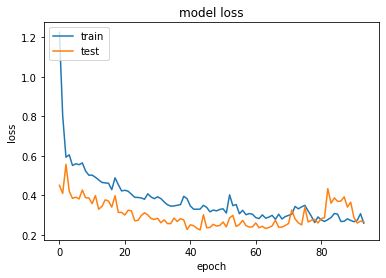

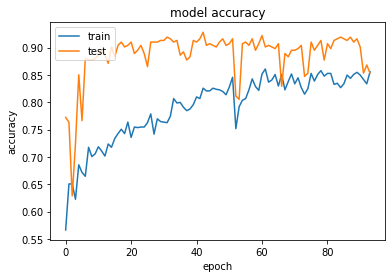

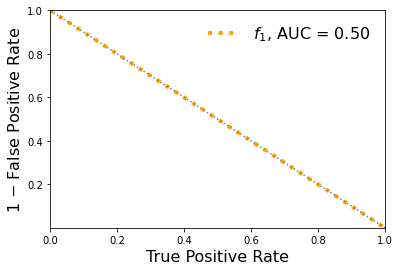

Classification score:


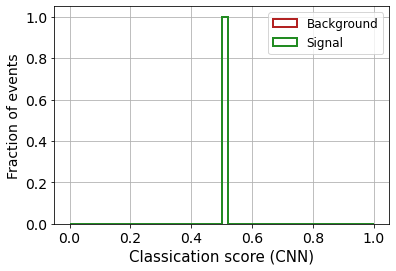


 ROC-AUC =  0.5


In [97]:

# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_cnn = model.predict(X_mon_test_cn)

# Compute ROC curve and ROC area for each class
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()
fpr_cnn, tpr_cnn, _ = roc_curve(y_mon_test, y_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)


plt.figure()
plt.plot(tpr_cnn,1-fpr_cnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_cnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_cnn[i,0])
    else:
        pred_XG_NP.append(y_pred_cnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (CNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_cnn)